# Predicting Nonlinear FEA Results with Machine Learning

**Author:** Copyright (c) 2025 Nahbruhh - Nguyen Manh Tuan (https://github.com/Nahbruhh)

This notebook demonstrates the process of building a machine learning model to predict nonlinear Finite Element Analysis (FEA) results (stress and strain) from linear FEA outputs. We will walk through the steps of loading and preprocessing the data, exploring the relationships between features and labels, selecting and training appropriate models, evaluating their performance, and saving the trained models for later use.

**Steps covered in this notebook:**

1.  **Data Loading:** Loading the dataset containing linear and nonlinear FEA results.
2.  **Data Preprocessing:** Scaling and splitting the data for training and testing.
3.  **Exploratory Data Analysis (EDA):** Visualizing data distributions and correlations.
4.  **Model Selection, Training and Saving:** Choosing, training regression models (Random Forest, XGBoost). And saving the trained models and scalers for deployment.
5.  **Model Evaluation:** Assessing the performance of the trained models.



## **0. Import:**


In [1]:
# Import libraries
import pandas as pd  
import numpy as np   
import joblib        

# Scikit-learn 
from sklearn.model_selection import train_test_split, RandomizedSearchCV, learning_curve
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# IPython widgets for interactive elements (if needed)
from IPython.display import display, clear_output
import ipywidgets as widgets

# PyTorch 
import torch

# Datetime 
from datetime import datetime

## **1. Data Loading:**


In [2]:
#Load data
data_path = '../data/data_training.csv'  
df = pd.read_csv(data_path)

#Load info
display(df.head())

# Define input features (X) and output labels (Y)
X_columns = ['Sigma_linear_VM', 'Sigma_linear_MaxP', 'Epsilon_linear_Equiv']
Y_columns = ['Sigma_nonlinear_VM', 'Sigma_nonlinear_MaxP', 'Epsilon_nonlinear_Plastic', 
             'Epsilon_nonlinear_Total', 'Epsilon_nonlinear_Elastic']

X = df[X_columns]
y = df[Y_columns]


,E,Et,Sigma_y,Sigma_linear_VM,Sigma_linear_MaxP,Epsilon_linear_Equiv,Sigma_nonlinear_VM,Sigma_nonlinear_MaxP,Epsilon_nonlinear_Plastic,Epsilon_nonlinear_Total,Epsilon_nonlinear_Elastic
0,210.0,1450.0,250.0,340.152341,376.170872,0.001701,256.969516,289.431182,0.000582,0.001837,0.001285
1,210.0,1450.0,250.0,742.458034,822.655297,0.003713,456.448510,530.451346,0.142280,0.144569,0.002290
2,210.0,1450.0,250.0,15.276877,16.785102,0.000076,15.276102,16.784154,0.000000,0.000076,0.000076
3,210.0,1450.0,250.0,19.682425,21.835217,0.000098,19.682100,21.834703,0.000000,0.000098,0.000098
4,210.0,1450.0,250.0,614.144310,674.681316,0.003071,425.503722,475.923559,0.120212,0.122341,0.002129


## **2. Data Processing:**


In [3]:
#Clean data
data_combined = pd.concat([pd.DataFrame(X, columns=X.columns), 
                          pd.DataFrame(y, columns=y.columns)], axis=1)
data_clean = data_combined.dropna()
print(f"Original data rows: {len(data_combined)}, Cleaned data rows: {len(data_clean)}")

X_clean = data_clean[X.columns]
y_clean = data_clean[y.columns]

# Normalize
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X_clean)
y_scaled = scaler_y.fit_transform(y_clean)

X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)
y_scaled_df = pd.DataFrame(y_scaled, columns=y.columns)

# Display test data
print("First 5 rows of scaled X:")
display(X_scaled_df.head())
print("First 5 rows of scaled y:")
display(y_scaled_df.head())

# Split data (70-15-15)
X_train_val, X_test, y_train_val, y_test = train_test_split(X_scaled, y_scaled, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=15/85, random_state=42) 


Original data rows: 482, Cleaned data rows: 200
First 5 rows of scaled X:


,Sigma_linear_VM,Sigma_linear_MaxP,Epsilon_linear_Equiv
0,0.026022,0.029025,0.026020
1,2.021427,2.033561,2.021705
2,-1.585334,-1.584473,-1.585318
3,-1.563483,-1.561800,-1.563495
4,1.385001,1.369217,1.384972


First 5 rows of scaled y:


,Sigma_nonlinear_VM,Sigma_nonlinear_MaxP,Epsilon_nonlinear_Plastic,Epsilon_nonlinear_Total,Epsilon_nonlinear_Elastic
0,0.184639,0.149460,-0.578393,-0.570253,0.182212
1,1.958399,1.988627,2.995739,2.990922,1.964960
2,-1.964491,-1.931044,-0.593083,-0.614172,-1.962921
3,-1.925313,-1.892504,-0.593083,-0.613623,-1.923882
4,1.683239,1.572539,2.439110,2.436332,1.680237


## **3. Data Exploration:**


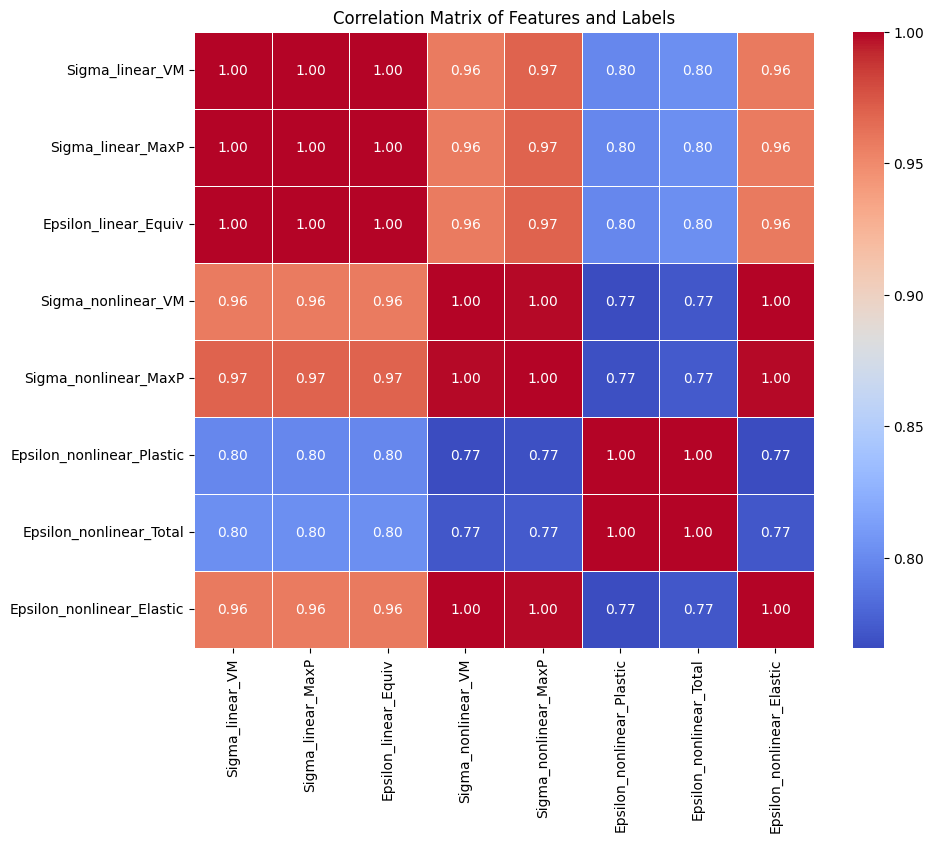

In [4]:
# Correlation analysis
data_combined = pd.concat([X, y], axis=1)
correlation_matrix = data_combined.corr()

# Plot correlation
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Features and Labels')
plt.show()



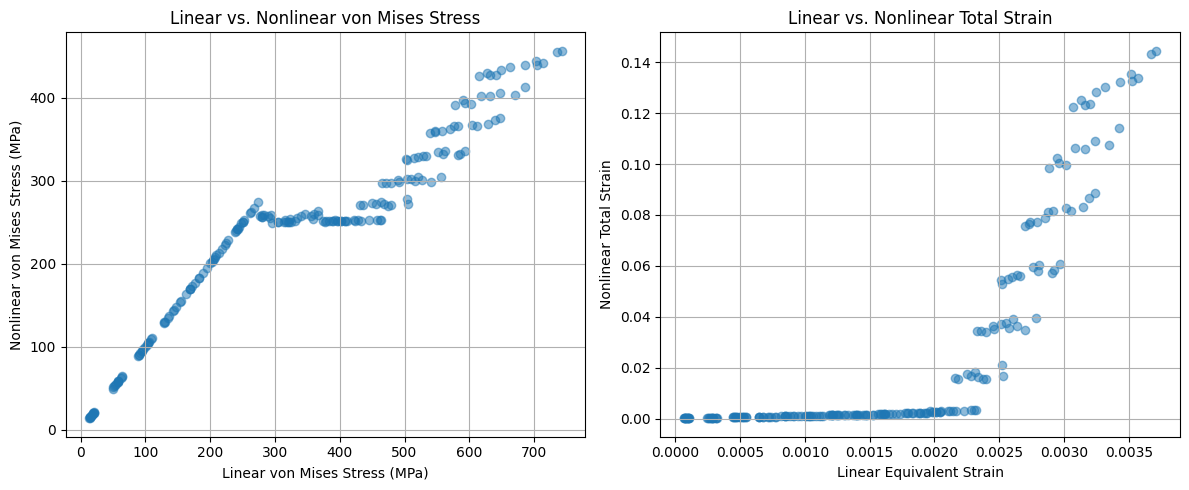

In [5]:
# Scatter plots: Linear vs Nonlinear results
plt.figure(figsize=(12, 5))

# von Mises Stress
plt.subplot(1, 2, 1)
plt.scatter(X['Sigma_linear_VM'], y['Sigma_nonlinear_VM'], alpha=0.5)
plt.xlabel('Linear von Mises Stress (MPa)')
plt.ylabel('Nonlinear von Mises Stress (MPa)')
plt.title('Linear vs. Nonlinear von Mises Stress')
plt.grid(True)

# Total Strain
plt.subplot(1, 2, 2)
plt.scatter(X['Epsilon_linear_Equiv'], y['Epsilon_nonlinear_Total'], alpha=0.5)
plt.xlabel('Linear Equivalent Strain')
plt.ylabel('Nonlinear Total Strain')
plt.title('Linear vs. Nonlinear Total Strain')
plt.grid(True)

plt.tight_layout()
plt.show()



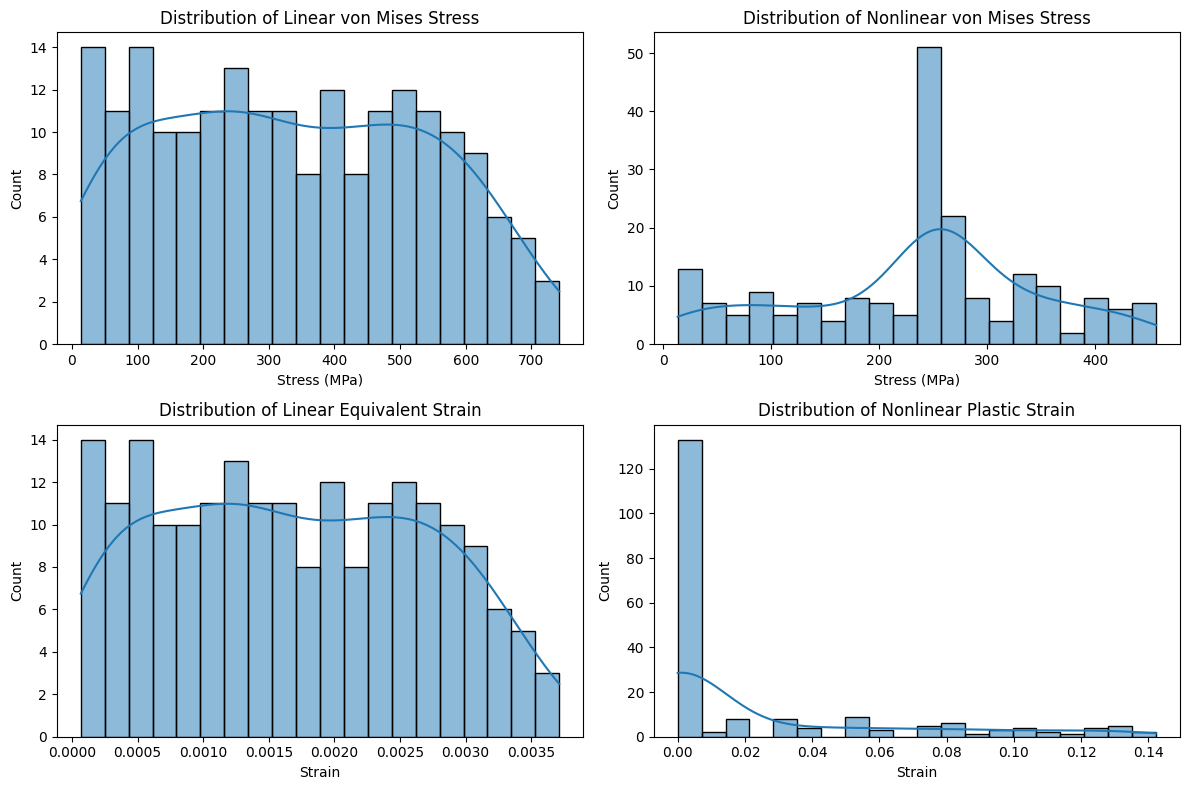

In [6]:
# Distribution plots 
plt.figure(figsize=(12, 8))

# Linear von Mises Stress
plt.subplot(2, 2, 1)
sns.histplot(X['Sigma_linear_VM'], bins=20, kde=True)
plt.title('Distribution of Linear von Mises Stress')
plt.xlabel('Stress (MPa)')

# Nonlinear von Mises Stress
plt.subplot(2, 2, 2)
sns.histplot(y['Sigma_nonlinear_VM'], bins=20, kde=True)
plt.title('Distribution of Nonlinear von Mises Stress')
plt.xlabel('Stress (MPa)')

# Linear Equivalent Strain
plt.subplot(2, 2, 3)
sns.histplot(X['Epsilon_linear_Equiv'], bins=20, kde=True)
plt.title('Distribution of Linear Equivalent Strain')
plt.xlabel('Strain')

# Nonlinear Plastic Strain
plt.subplot(2, 2, 4)
sns.histplot(y['Epsilon_nonlinear_Plastic'], bins=20, kde=True)
plt.title('Distribution of Nonlinear Plastic Strain')
plt.xlabel('Strain')

plt.tight_layout()
plt.show()

## **4. Model Selection, Training and Saving:** 



Training Random Forest...

Random Forest Validation Results:
Best Params: {'estimator__n_estimators': 400, 'estimator__min_samples_split': 2, 'estimator__min_samples_leaf': 4, 'estimator__max_depth': 20}
MSE: 0.012415993472394072
R²: 0.9776229082073093

RandomForest model and scalers saved.


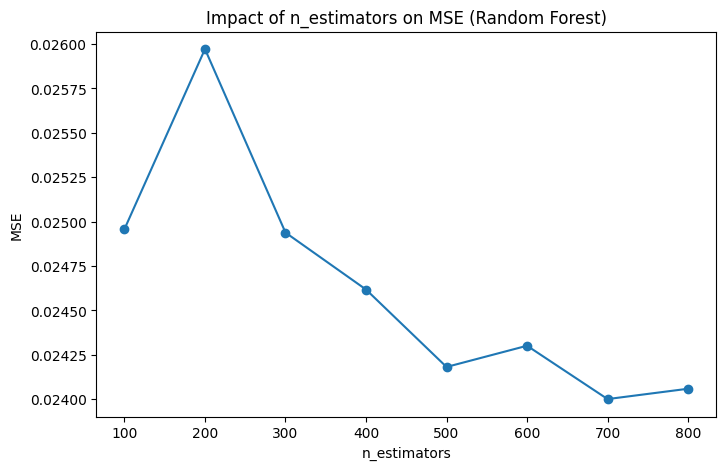

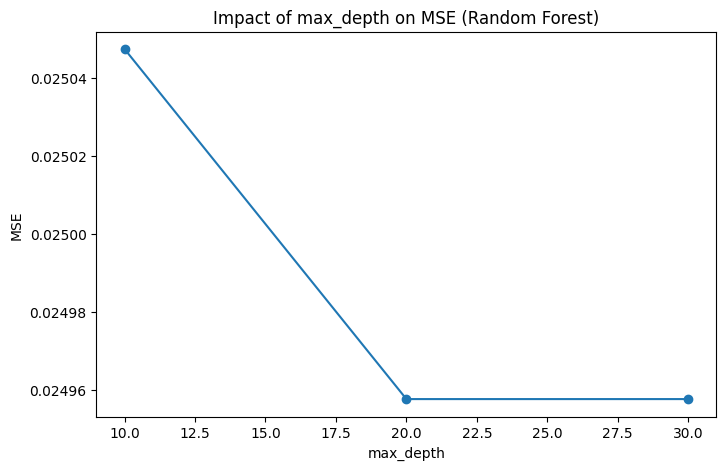

In [7]:
# Hyperparameter
rf_params = {
    'estimator__n_estimators': [100, 200, 300, 400, 500, 600, 700, 800],
    'estimator__max_depth': [None, 10, 20, 30],
    'estimator__min_samples_split': [2, 5, 10],
    'estimator__min_samples_leaf': [1, 2, 4]
}

# Init
rf_base = RandomForestRegressor(random_state=42)
rf_multi = MultiOutputRegressor(rf_base)

# Tuning
rf_search = RandomizedSearchCV(rf_multi, rf_params, n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42, n_jobs=-1)

# Train RF
print("Training Random Forest...")
rf_search.fit(X_train, y_train)

# Save best config
best_rf = rf_search.best_estimator_
rf_pred_val = best_rf.predict(X_val)

# Evaluate 
rf_mse_val = mean_squared_error(y_val, rf_pred_val)
rf_r2_val = r2_score(y_val, rf_pred_val)

print("\nRandom Forest Validation Results:")
print("Best Params:", rf_search.best_params_)
print("MSE:", rf_mse_val)
print("R²:", rf_r2_val)
# Save model
joblib.dump(best_rf, '../models/best_rf_model.joblib')
joblib.dump(scaler_X, '../models/scaler_X_rf.joblib')
joblib.dump(scaler_y, '../models/scaler_y_rf.joblib')
print("\nRandomForest model and scalers saved.")

# Visualisation
n_estimators_results = []
for n in rf_params['estimator__n_estimators']:
    rf_temp = MultiOutputRegressor(RandomForestRegressor(n_estimators=n, random_state=42))
    rf_temp.fit(X_train, y_train)
    mse = mean_squared_error(y_val, rf_temp.predict(X_val))
    n_estimators_results.append(mse)

plt.figure(figsize=(8, 5))
plt.plot(rf_params['estimator__n_estimators'], n_estimators_results, marker='o')
plt.title('Impact of n_estimators on MSE (Random Forest)')
plt.xlabel('n_estimators')
plt.ylabel('MSE')
plt.show()


max_depth_results = []
for depth in rf_params['estimator__max_depth']:
    rf_temp = MultiOutputRegressor(RandomForestRegressor(max_depth=depth, random_state=42))
    rf_temp.fit(X_train, y_train)
    mse = mean_squared_error(y_val, rf_temp.predict(X_val))
    max_depth_results.append(mse)

plt.figure(figsize=(8, 5))
plt.plot(rf_params['estimator__max_depth'], max_depth_results, marker='o')
plt.title('Impact of max_depth on MSE (Random Forest)')
plt.xlabel('max_depth')
plt.ylabel('MSE')
plt.show()

In [8]:

!pip install xgboost


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



Training XGB...

XGBoost Validation Results:
Best Params: {'estimator__subsample': 0.9, 'estimator__n_estimators': 100, 'estimator__max_depth': 7, 'estimator__learning_rate': 0.1}
MSE: 0.029318684728700185
R²: 0.9472168726967631

XGBoost model and scalers saved.


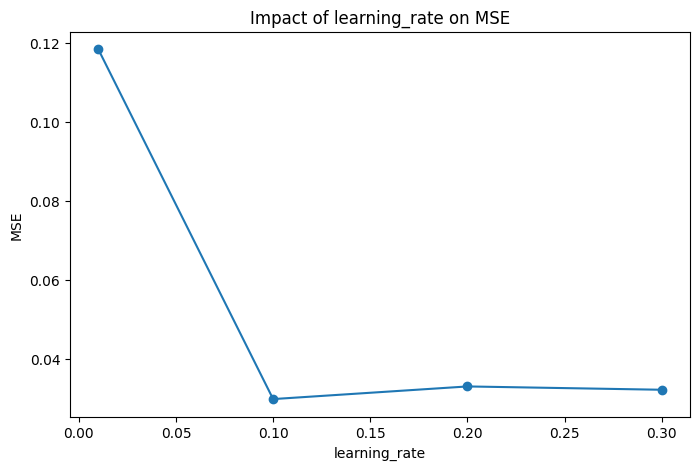

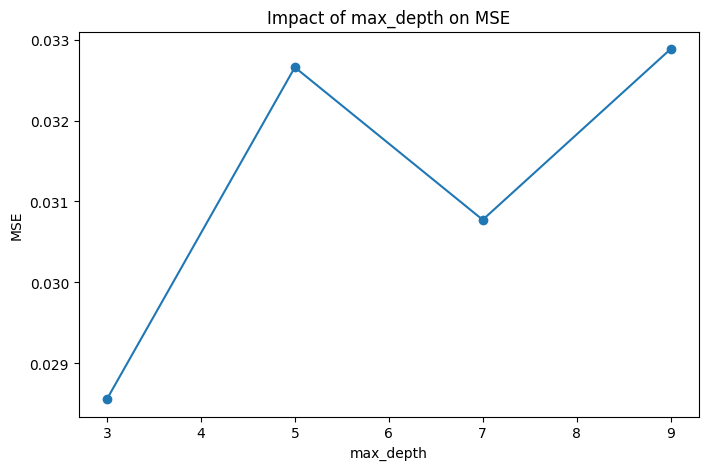

In [9]:
from xgboost import XGBRegressor

xgb_params = {
        'estimator__n_estimators': [100, 200, 300],
        'estimator__max_depth': [3, 5, 7, 9],           
        'estimator__learning_rate': [0.01, 0.1, 0.2, 0.3], 
        'estimator__subsample': [0.7, 0.8, 0.9]
    }
xgb_base = XGBRegressor(random_state=42)
xgb_multi = MultiOutputRegressor(xgb_base)

# Tuning
xgb_search = RandomizedSearchCV(xgb_multi, xgb_params, n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42, n_jobs=-1)

# Train XGB
print("\nTraining XGB...")
xgb_search.fit(X_train, y_train)

# Save best config
best_xgb = xgb_search.best_estimator_
xgb_pred_val = best_xgb.predict(X_val)

# Evaluate 
xgb_mse_val = mean_squared_error(y_val, xgb_pred_val)
xgb_r2_val = r2_score(y_val, xgb_pred_val)

print("\nXGBoost Validation Results:")
print("Best Params:", xgb_search.best_params_)
print("MSE:", xgb_mse_val)
print("R²:", xgb_r2_val)

#Save XGB model
joblib.dump(best_xgb, '../models/best_xgb_model.joblib')
joblib.dump(scaler_X, '../models/scaler_X_xgb.joblib')
joblib.dump(scaler_y, '../models/scaler_y_xgb.joblib')
print("\nXGBoost model and scalers saved.")


learning_rate_results = []
for lr in xgb_params['estimator__learning_rate']:
    xgb_temp = MultiOutputRegressor(XGBRegressor(learning_rate=lr, random_state=42))
    xgb_temp.fit(X_train, y_train)
    mse = mean_squared_error(y_val, xgb_temp.predict(X_val))
    learning_rate_results.append(mse)

plt.figure(figsize=(8, 5))
plt.plot(xgb_params['estimator__learning_rate'], learning_rate_results, marker='o')
plt.title('Impact of learning_rate on MSE')
plt.xlabel('learning_rate')
plt.ylabel('MSE')
plt.show()


max_depth_results_xgb = []
for depth in xgb_params['estimator__max_depth']:
    xgb_temp = MultiOutputRegressor(XGBRegressor(max_depth=depth, random_state=42))
    xgb_temp.fit(X_train, y_train)
    mse = mean_squared_error(y_val, xgb_temp.predict(X_val))
    max_depth_results_xgb.append(mse)

plt.figure(figsize=(8, 5))
plt.plot(xgb_params['estimator__max_depth'], max_depth_results_xgb, marker='o')
plt.title('Impact of max_depth on MSE')
plt.xlabel('max_depth')
plt.ylabel('MSE')
plt.show()



## **5. Evaluation:** 

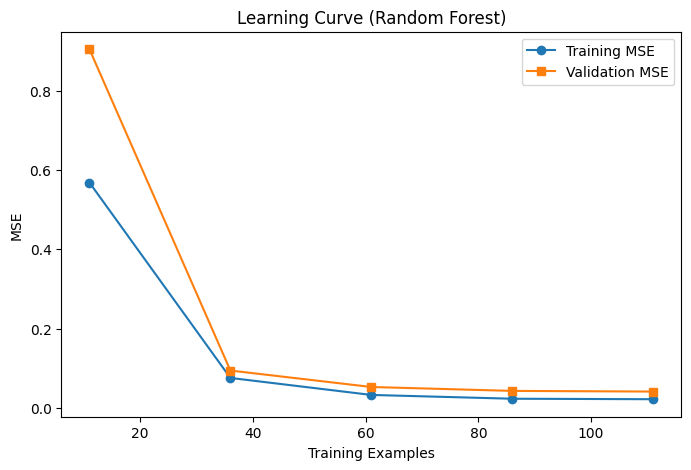

In [10]:
# Learning Curve RF
train_sizes, train_scores, val_scores = learning_curve(best_rf, X_train, y_train, cv=5,
                                                       scoring='neg_mean_squared_error',
                                                       train_sizes=np.linspace(0.1, 1.0, 5), n_jobs=-1
                                                      )

train_scores_mean = -train_scores.mean(axis=1)
val_scores_mean = -val_scores.mean(axis=1)

plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_scores_mean, label='Training MSE',marker ='o')
plt.plot(train_sizes, val_scores_mean, label='Validation MSE',marker = 's')
plt.title('Learning Curve (Random Forest)')
plt.xlabel('Training Examples')
plt.ylabel('MSE')
plt.legend()
plt.show()

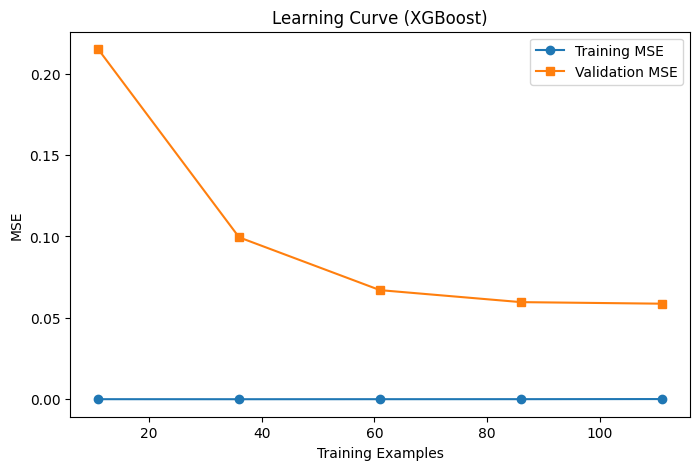

In [11]:
#Learning Curve XGB
train_sizes_xgb, train_scores_xgb, val_scores_xgb = learning_curve(best_xgb, X_train, y_train, cv=5,
                                                                   scoring='neg_mean_squared_error',
                                                                   train_sizes=np.linspace(0.1, 1.0, 5),
                                                                   n_jobs=-1
                                                                  )

train_scores_mean_xgb = -train_scores_xgb.mean(axis=1)
val_scores_mean_xgb = -val_scores_xgb.mean(axis=1)

plt.figure(figsize=(8, 5))
plt.plot(train_sizes_xgb, train_scores_mean_xgb, label='Training MSE',marker ='o')
plt.plot(train_sizes_xgb, val_scores_mean_xgb, label='Validation MSE',marker ='s')
plt.title('Learning Curve (XGBoost)')
plt.xlabel('Training Examples')
plt.ylabel('MSE')
plt.legend()
plt.show()


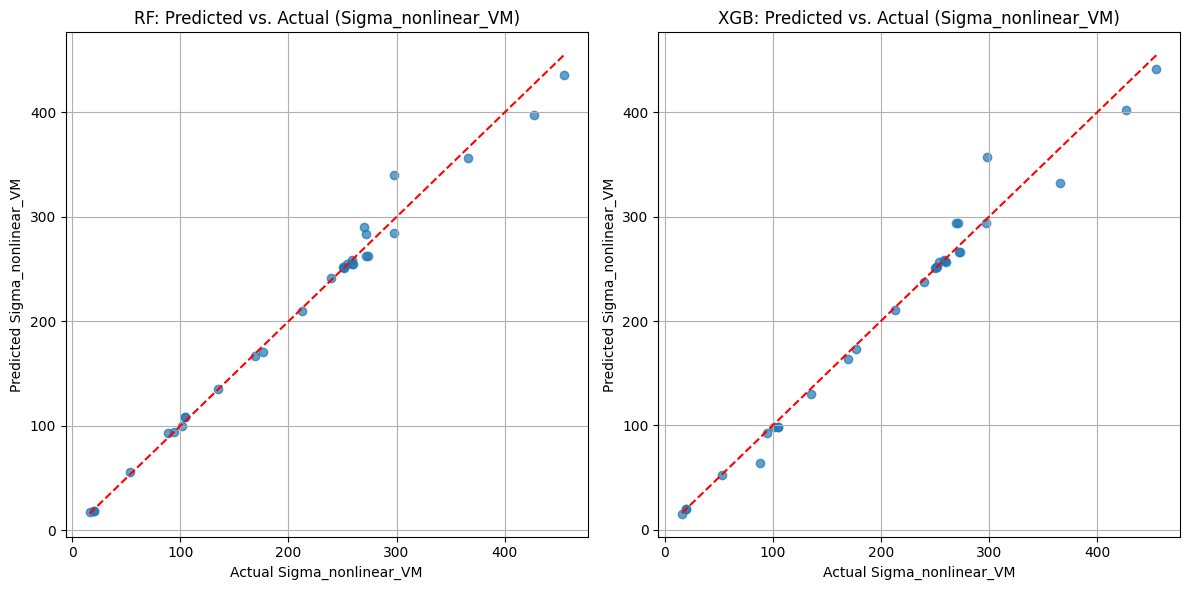

In [12]:
#Predicted vs Actual Visualization
rf_pred_test = best_rf.predict(X_test)
rf_mse_test = mean_squared_error(y_test, rf_pred_test)
rf_r2_test = r2_score(y_test, rf_pred_test)


rf_pred_test_original = scaler_y.inverse_transform(rf_pred_test)
y_test_original = scaler_y.inverse_transform(y_test)


sigma_vm_index = list(y.columns).index('Sigma_nonlinear_VM')

plt.figure(figsize=(12, 6))

# RF plot
plt.subplot(1, 2, 1)
plt.scatter(y_test_original[:, sigma_vm_index], rf_pred_test_original[:, sigma_vm_index], alpha=0.7)
plt.plot(
    [min(y_test_original[:, sigma_vm_index]), max(y_test_original[:, sigma_vm_index])],
    [min(y_test_original[:, sigma_vm_index]), max(y_test_original[:, sigma_vm_index])],
    color='red', linestyle='--'
)
plt.title('RF: Predicted vs. Actual (Sigma_nonlinear_VM)')
plt.xlabel('Actual Sigma_nonlinear_VM')
plt.ylabel('Predicted Sigma_nonlinear_VM')
plt.grid(True)

# XGB plot
xgb_pred_test = best_xgb.predict(X_test)
xgb_mse_test = mean_squared_error(y_test, xgb_pred_test)
xgb_r2_test = r2_score(y_test, xgb_pred_test)
xgb_pred_test_original = scaler_y.inverse_transform(xgb_pred_test)

plt.subplot(1, 2, 2)
plt.scatter(y_test_original[:, sigma_vm_index], xgb_pred_test_original[:, sigma_vm_index], alpha=0.7)
plt.plot(
        [min(y_test_original[:, sigma_vm_index]), max(y_test_original[:, sigma_vm_index])],
        [min(y_test_original[:, sigma_vm_index]), max(y_test_original[:, sigma_vm_index])],
        color='red', linestyle='--'
        )
plt.title('XGB: Predicted vs. Actual (Sigma_nonlinear_VM)')
plt.xlabel('Actual Sigma_nonlinear_VM')
plt.ylabel('Predicted Sigma_nonlinear_VM')
plt.grid(True)

plt.tight_layout()
plt.show()